# multi label classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T
import torchvision.models as models
import timm
from torchvision.datasets import ImageFolder

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

In [ ]:
df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/5/data/cs11498939292983011494.csv')
df.columns

In [ ]:
df.columns = ['name', 'val', 'varients']
df.loc[17] = ['eye_angle', ' 1', ' 3']

In [ ]:
df

## 새로운 annotaion dataframe 생성

In [ ]:
columns = ['filename', 'glasses', 'eye_color', 'eyebrow_width']
new_df = pd.DataFrame(columns=columns)
new_df

In [ ]:
path_list = os.listdir('/Users/kimhongseok/cv_79_projects/part1/chapter3/5/data')
csv_list = []
img_list = []

for path in path_list:
    if path.endswith('.csv'):
        csv_list.append(path)
    else :
        img_list.append(path)

print(len(csv_list))
print(len(img_list))

In [ ]:
root_path = '/Users/kimhongseok/cv_79_projects/part1/chapter3/5/data'

for i in range(len(csv_list)):
    new_row = {'filename': img_list[i]}
    path = os.path.join(root_path, csv_list[i])
    df = pd.read_csv(path)
    df.columns = ['name', 'val', 'varients']

    for idx, row in df.iterrows():
        if row['name'] in columns:
            new_row[row['name']] = row['val']

    new_df.loc[i] = new_row

In [ ]:
new_df

In [ ]:
max_categories = []
for col in new_df.columns[1:]:
    max_categories.append(new_df[col].max())

max_categories

In [ ]:
new_df.to_csv('annotations.csv', index=False)

### 클래스들을 one-hot vector로 표현

In [3]:
annotations_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/5/annotations.csv')
annotations_df

,filename,glasses,eye_color,eyebrow_width
0,cs10398371138482662938.png,11,2,1
1,cs1022724317930192998.png,11,3,0
2,cs10410419915843824966.png,4,0,1
3,cs11270409558439850835.png,8,2,1
4,cs10412294937479957813.png,11,4,1
...,...,...,...,...
9995,cs10209842947309158505.png,6,1,2
9996,cs10733639600650908185.png,5,1,0
9997,cs10702794071560322950.png,11,4,1
9998,cs11328176763022815016.png,11,2,1


In [4]:
max_categories = []
for col in annotations_df.columns[1:]:
    max_categories.append(annotations_df[col].max())

max_categories

[11, 4, 2]

In [5]:
class_list = annotations_df.columns[1:]
annotations_df = pd.get_dummies(annotations_df, columns=class_list, dtype=int)
annotations_df

,filename,glasses_0,glasses_1,glasses_2,glasses_3,glasses_4,glasses_5,glasses_6,glasses_7,glasses_8,...,glasses_10,glasses_11,eye_color_0,eye_color_1,eye_color_2,eye_color_3,eye_color_4,eyebrow_width_0,eyebrow_width_1,eyebrow_width_2
0,cs10398371138482662938.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,cs1022724317930192998.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
2,cs10410419915843824966.png,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,cs11270409558439850835.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
4,cs10412294937479957813.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,cs10209842947309158505.png,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
9996,cs10733639600650908185.png,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
9997,cs10702794071560322950.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
9998,cs11328176763022815016.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0


In [6]:
annotations_df.sum()

filename           cs10398371138482662938.pngcs102272431793019299...
glasses_0                                                        490
glasses_1                                                        459
glasses_2                                                        443
glasses_3                                                        453
glasses_4                                                        451
glasses_5                                                        453
glasses_6                                                        466
glasses_7                                                        445
glasses_8                                                        440
glasses_9                                                        439
glasses_10                                                       475
glasses_11                                                      4986
eye_color_0                                                     2013
eye_color_1                       

In [7]:
annotations_df.iloc[0, 1:].tolist()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]

# CustomDataset

In [30]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_df, root_path, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms
        self.root_path = root_path
        l = annotations_df.shape[0]

        for i in range(l):
            img = annotations_df.iloc[i, 0]
            labels = annotations_df.iloc[i, 1:]
            self.data.append((img, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.data[idx][0])
        img = Image.open(img_path).convert('RGB')
        img = self.transforms(img)
        labels = torch.tensor(self.data[idx][1].tolist()).to(torch.float)

        return img, labels

In [31]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

total_dataset = CustomDataset(annotations_df, '/Users/kimhongseok/cv_79_projects/part1/chapter3/5/data', transforms)

In [32]:
len(total_dataset)

10000

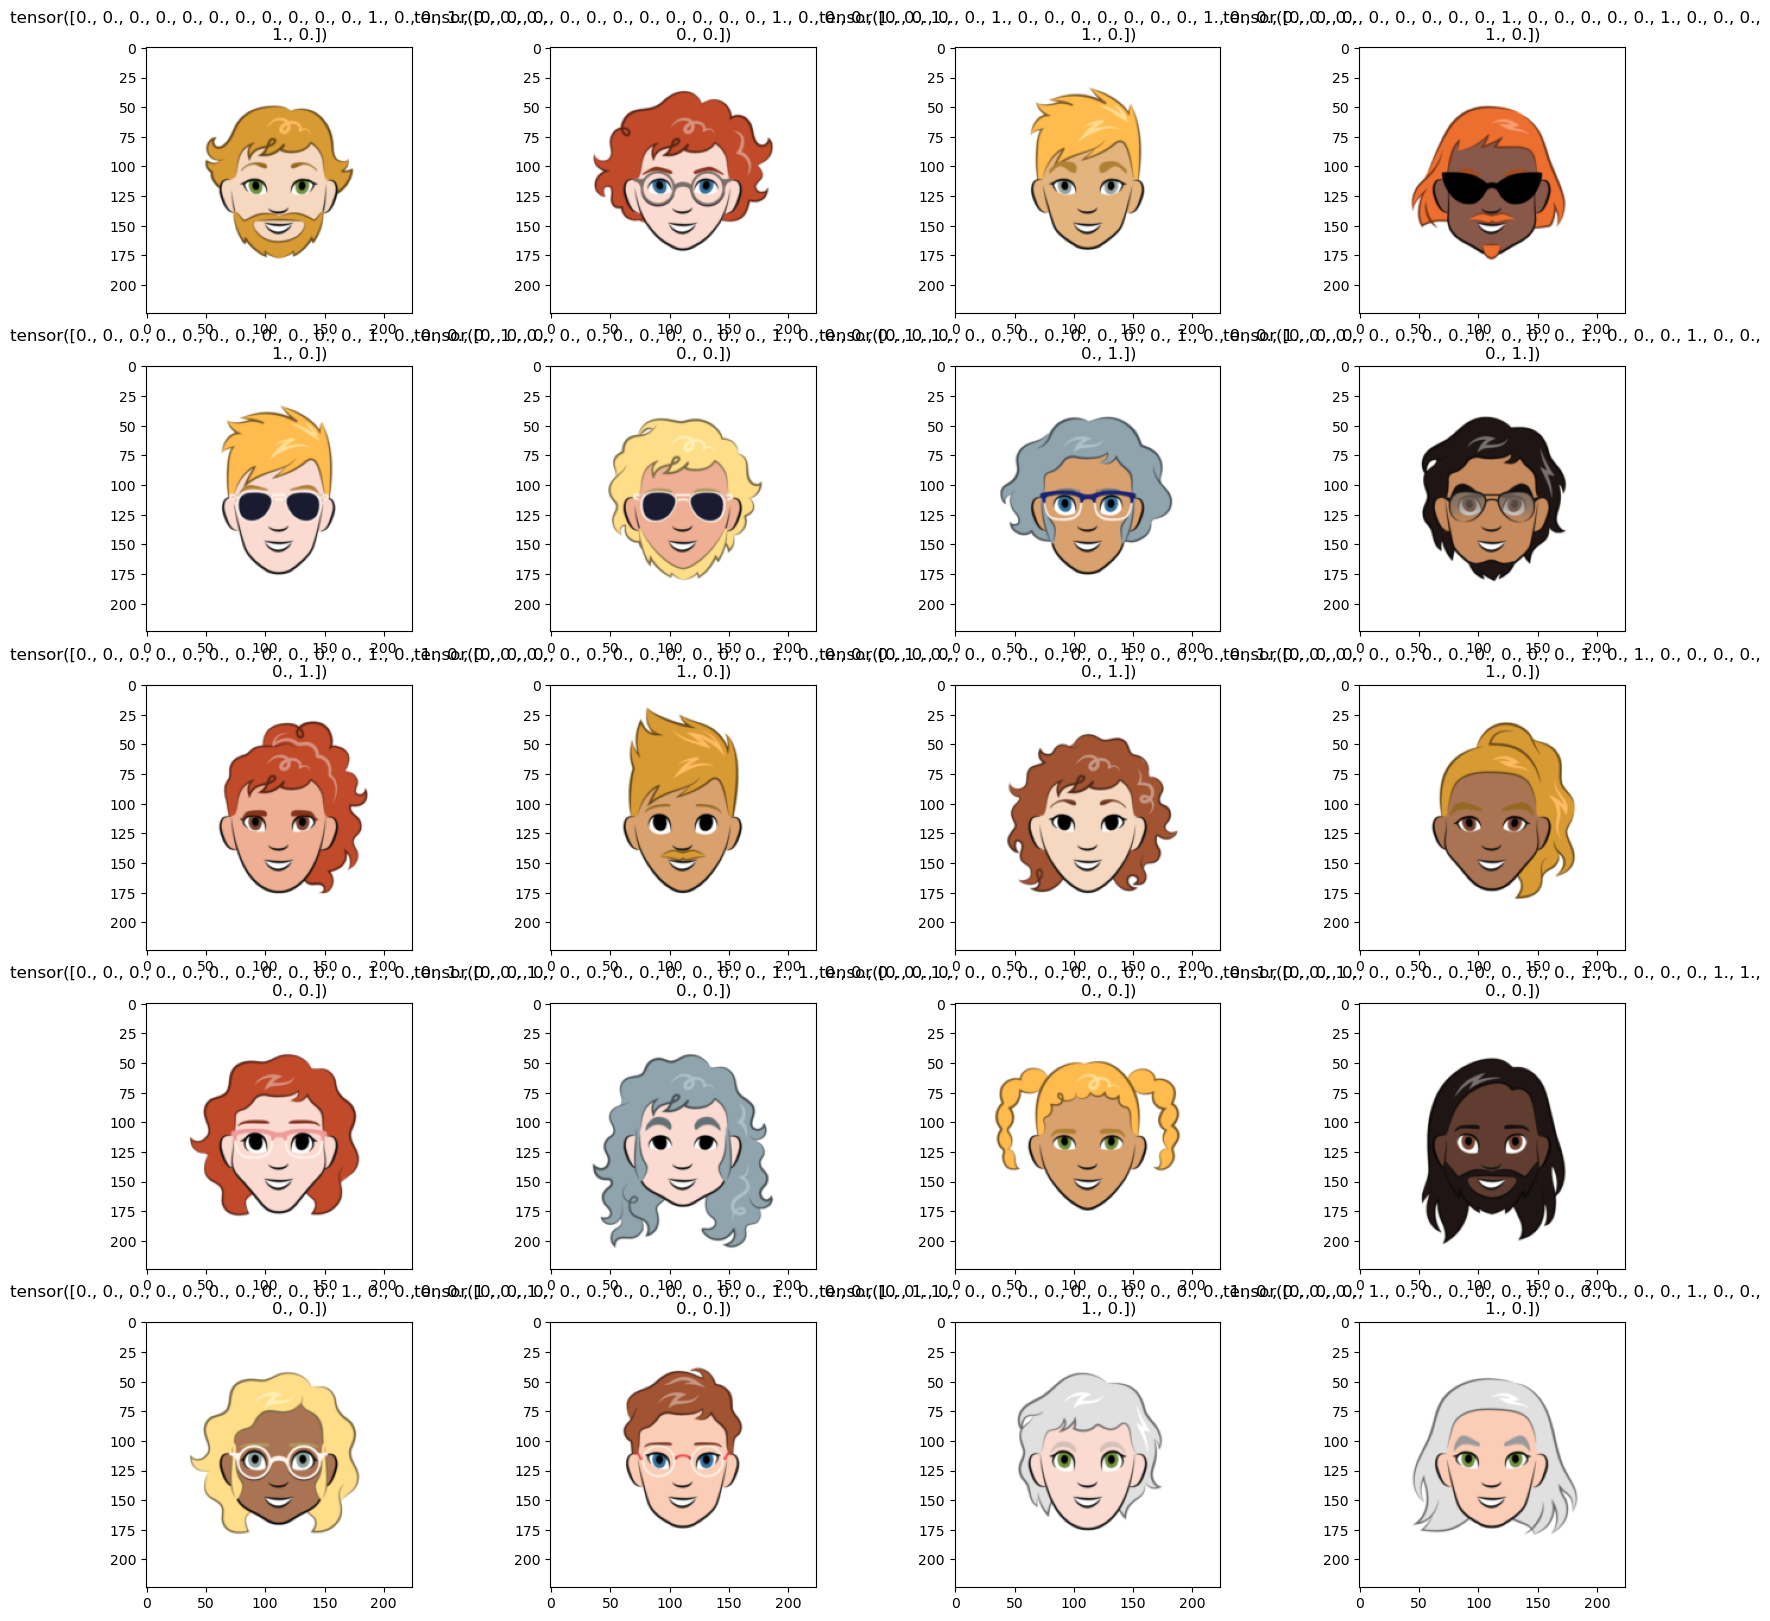

In [33]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(5, 4, i+1)
    plt.imshow(total_dataset[i][0].permute(1, 2, 0))
    plt.title(total_dataset[i][1])

In [34]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num, valid_num, test_num])

print(len(train_dataset), len(valid_dataset), len(test_dataset))

8000 1000 1000


In [35]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=100, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# train, eval

In [40]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        preds = (torch.sigmoid(outputs)>threshold).float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = (torch.sigmoid(outputs)>threshold).float()

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    train_loss_list = []
    train_f1_list = []
    valid_loss_list = []
    valid_f1_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evaluation(model, train_dataloader, criterion, threshold, epoch, num_epochs)

        train_loss_list.append(train_loss)
        train_f1_list.append(train_f1)
        valid_loss_list.append(valid_loss)
        valid_f1_list.append(valid_f1)

        print(f'Train Loss: {train_loss}, Train F1: {train_f1}, Valid Loss: {valid_loss}, Valid F1: {valid_f1}')

    return model, train_loss_list, train_f1_list, valid_loss_list, valid_f1_list

# model

In [41]:
model = timm.create_model(
    'resnet34',
    pretrained=True,
    num_classes = len(annotations_df.columns)-1
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [42]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [43]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, train_loss_list, train_f1_list, valid_loss_list, valid_f1_list = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, 0.5, 10)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.3989601947367191, Train F1: 0.04348285048065576, Valid Loss: 0.3616200193762779, Valid F1: 0.032648582214028624


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.36148487962782383, Train F1: 0.027288428324697755, Valid Loss: 0.3604443144053221, Valid F1: 0.026522667336430994


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.3603357680141926, Train F1: 0.02700632295719844, Valid Loss: 0.3594824645668268, Valid F1: 0.004312543473220496


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.3593814942985773, Train F1: 0.026452503450872127, Valid Loss: 0.35846734754741194, Valid F1: 0.030705651410269652


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.3583977673202753, Train F1: 0.026183772715638598, Valid Loss: 0.35750230513513087, Valid F1: 0.03191753364512742


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.3577157687395811, Train F1: 0.02651961398671513, Valid Loss: 0.356386112421751, Valid F1: 0.030519273654029944


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.35692478120327, Train F1: 0.02693022679390259, Valid Loss: 0.3558013513684273, Valid F1: 0.030213755676154613


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.35630214437842367, Train F1: 0.026420316246181557, Valid Loss: 0.35494934134185313, Valid F1: 0.02386581941776267


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.35539857782423495, Train F1: 0.027152899824253073, Valid Loss: 0.3545841991901398, Valid F1: 0.026582278481012654


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train Loss: 0.35485013015568256, Train F1: 0.02697923302319512, Valid Loss: 0.35349368676543236, Valid F1: 0.03134067290873547


Text(0.5, 1.0, 'Valid Accuracy')

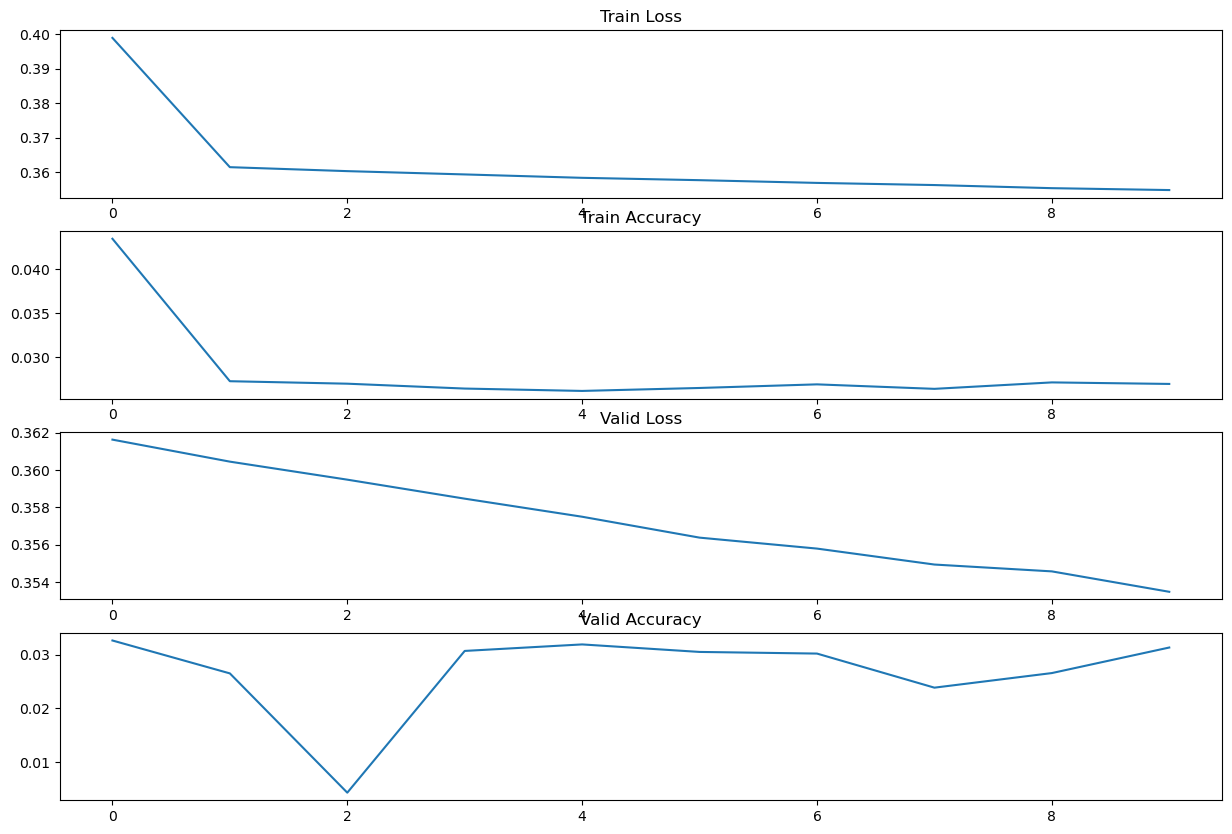

In [44]:
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(train_loss_list)
plt.title('Train Loss')

plt.subplot(4, 1, 2)
plt.plot(train_f1_list)
plt.title('Train Accuracy')

plt.subplot(4, 1, 3)
plt.plot(valid_loss_list)
plt.title('Valid Loss')

plt.subplot(4, 1, 4)
plt.plot(valid_f1_list)
plt.title('Valid Accuracy')

# Test

In [45]:
model.eval()
test_loss = 0.0
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>0.5).float()
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

test_loss /= len(test_dataloader)
test_f1 = f1_score(total_labels, total_preds, average='macro')

print(test_loss, test_f1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.3664109379053116 0.02813278008298755


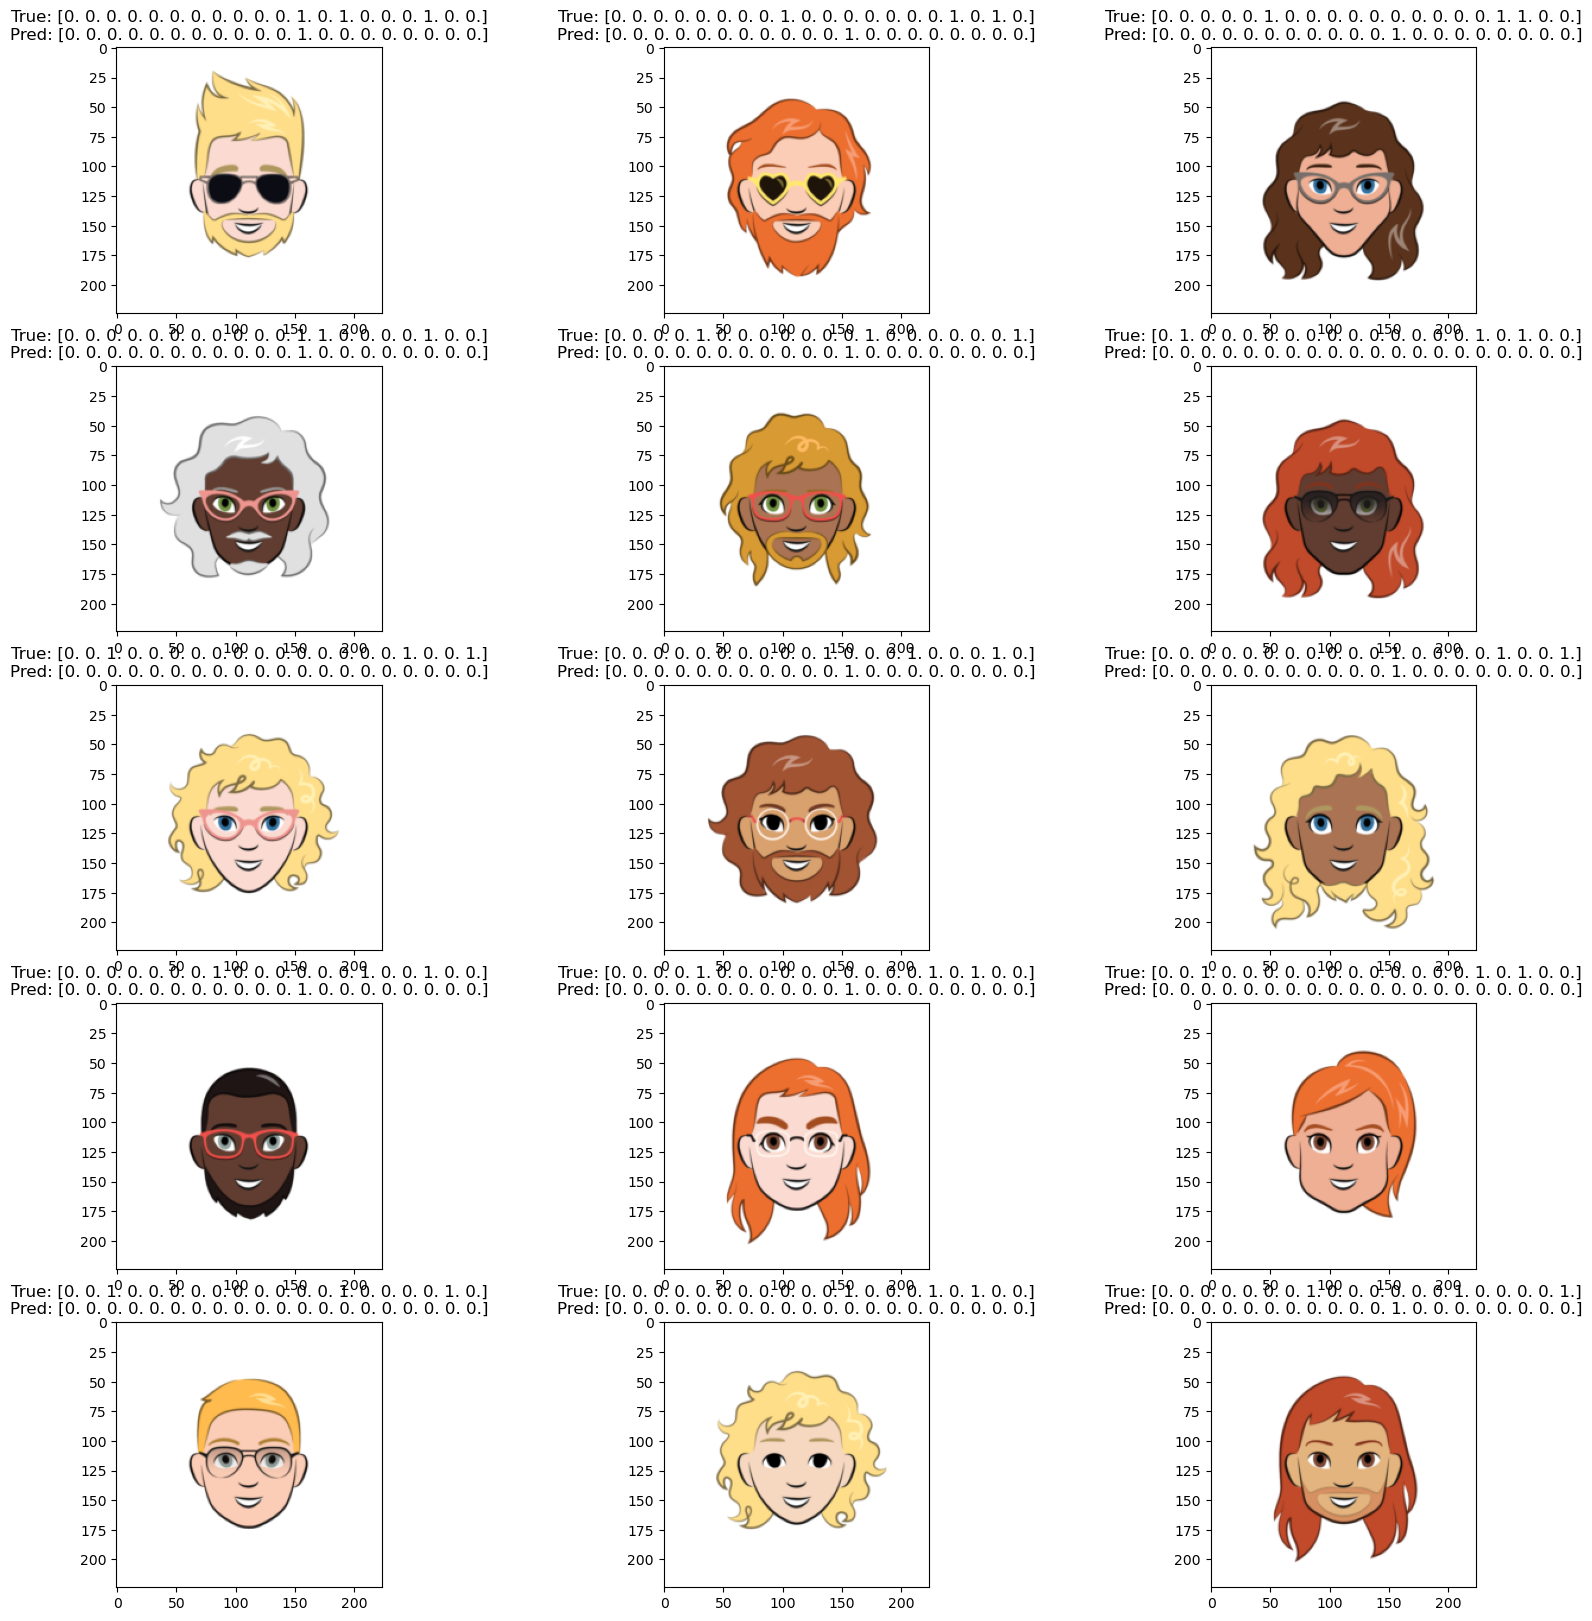

In [48]:
plt.figure(figsize=(20, 20))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {total_labels[i]}\nPred: {total_preds[i]}')